In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from colour_demosaicing import masks_CFA_Bayer
from timeit import default_timer as timer

from heuristic1 import heuristic_1
from heuristic2 import heuristic_2
from heuristic3 import heuristic_3
from heuristic4 import heuristic_4

Heuristic 2: N_t + mu_t 333.7764775492251 is larger than lpar 333.3333333333333 in channel 0
Heuristic 2: N_t + mu_t 333.54118471965194 is larger than lpar 333.3333333333333 in channel 1
Heuristic 2: N_t + mu_t 333.33334075985476 is larger than lpar 333.3333333333333 in channel 2
Heuristic 3: N_t + mu_t 333.59282018984527 is larger than lpar 333.3333333333333 in channel 0
Heuristic 3: N_t + mu_t 333.59282018984527 is larger than lpar 333.3333333333333 in channel 1
Heuristic 3: N_t + mu_t 333.59282018984527 is larger than lpar 333.3333333333333 in channel 2
Heuristic 4: N_t + mu_t 333.37255680561066 is larger than lpar 333.3333333333333 in channel 0
Heuristic 4: The region in channel 1 is too small: 2 pixels.
Heuristic 4: The region in channel 2 is too small: 2 pixels.
Heuristic 2: Sum of mu is 999.1059049922042. Store 5164 vertices. Run time is 13.521771800000352
Heuristic 3: Sum of mu is 999.6174646755677. Store 2583 vertices. Run time is 5.540168300000005
Heuristic 4: Sum of mu is 88

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


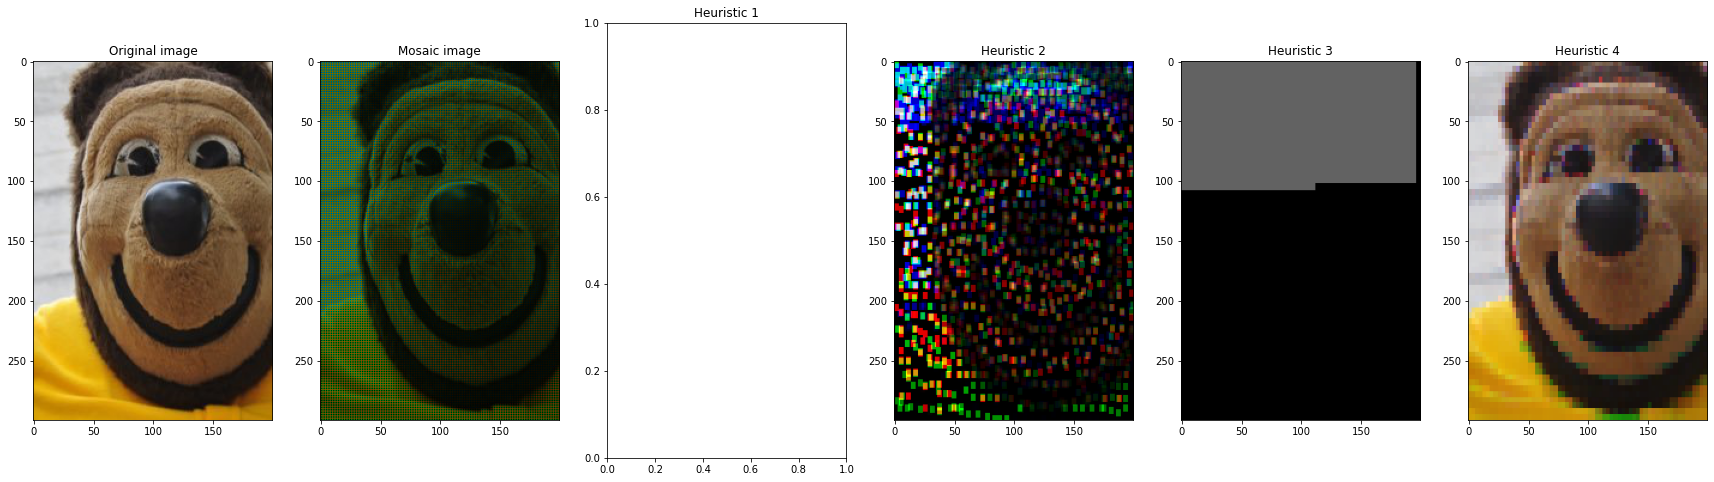

In [5]:
shape = (300, 200)
start = (50, 50)
image = imread('image/oski.png', 'png')   
image = image[start[0]:start[0]+shape[0], start[1]:start[1]+shape[1], :]

bayer_filter = np.stack(masks_CFA_Bayer(shape), axis=-1).astype(float)
mosaic_image = image * bayer_filter

lpar1 = 100
lpar2 = 1000
lpar3 = 1000
lpar4 = 1000

# start_1 = timer()
# _, Psi_1, mu_1, q_1 = heuristic_1(mosaic_image, [12, 8, 1], lpar=lpar1, tol=1e-2, verbose=False)
# end_1 = timer()

start_2 = timer()
Psi_2, mu_2, q_2 = heuristic_2(p_0=mosaic_image, block_shape=[6, 4], min_n_pix=4, lpars=[lpar2/3, lpar2/3, lpar2/3], verbose=False)
end_2 = timer()

start_3 = timer()
Psi_3, mu_3, q_3 = heuristic_3(p_0=mosaic_image, region_shape=[6, 4], lpars=[lpar3/3, lpar3/3, lpar3/3], verbose=False)
end_3 = timer()

start_4 = timer()
Psi_4, mu_4, q_4 = heuristic_4(p_0=mosaic_image, min_n_pix=4, lpars=[lpar4/3, lpar4/3, lpar4/3], verbose=False)
end_4 = timer()

# print(f'Heuristic 1: Sum of mu is {sum(mu_1)}. Store {len(q_1)} vertices. Run time is {end_1 - start_1}')
print(f'Heuristic 2: Sum of mu is {sum(mu_2)}. Store {len(q_2)} vertices. Run time is {end_2 - start_2}')
print(f'Heuristic 3: Sum of mu is {sum(mu_3)}. Store {len(q_3)} vertices. Run time is {end_3 - start_3}')
print(f'Heuristic 4: Sum of mu is {sum(mu_4)}. Store {len(q_4)} vertices. Run time is {end_4 - start_4}')

fig, axes = plt.subplots(1, 6, figsize=(30, 8))
axes[0].imshow(image)
axes[1].imshow(mosaic_image)
# axes[2].imshow(Psi_1)
axes[3].imshow(Psi_2)
axes[4].imshow(Psi_3)
axes[5].imshow(Psi_4)

axes[0].set_title('Original image')
axes[1].set_title('Mosaic image')
axes[2].set_title('Heuristic 1')
axes[3].set_title('Heuristic 2')
axes[4].set_title('Heuristic 3')
axes[5].set_title('Heuristic 4')
fig.savefig('comparison.png')


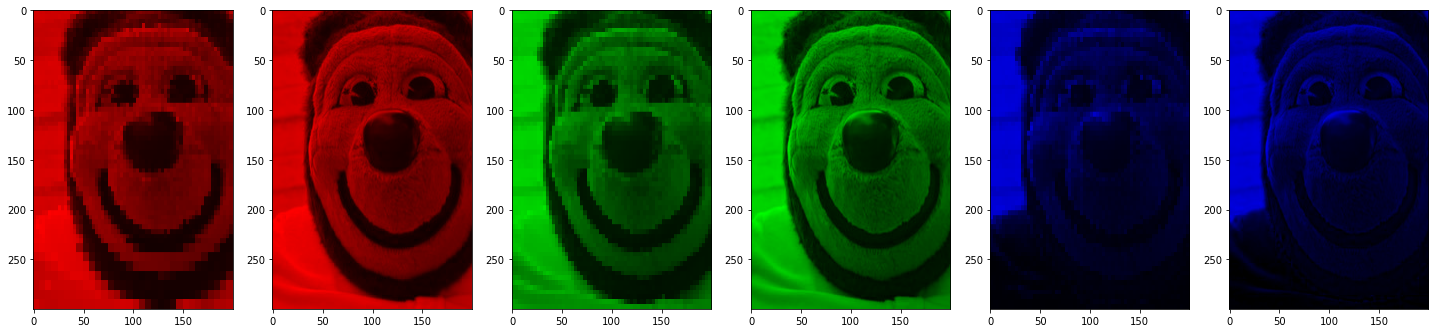

In [9]:
Psi_zeros = np.zeros(image.shape)
Psi_r = Psi_zeros.copy()
Psi_g = Psi_zeros.copy()
Psi_b = Psi_zeros.copy()
Psi_r[..., 0] = Psi_4[..., 0]
Psi_g[..., 1] = Psi_4[..., 1]
Psi_b[..., 2] = Psi_4[..., 2]

image_zeros = np.zeros(image.shape)
image_r = image_zeros.copy()
image_g = image_zeros.copy()
image_b = image_zeros.copy()
image_r[..., 0] = image[..., 0]
image_g[..., 1] = image[..., 1]
image_b[..., 2] = image[..., 2]

fig, axes = plt.subplots(1, 6, figsize=(25, 6))
axes[0].imshow(Psi_r)
axes[1].imshow(image_r)
axes[2].imshow(Psi_g)
axes[3].imshow(image_g)
axes[4].imshow(Psi_b)
axes[5].imshow(image_b)
plt.show()

**Observation:**

1. When `lpar` in `heuristic_1` is very large, the function cannot terminate correctly.
2. Some entries of `Psi_2` have values larger than 1.
3. There will be a memory issue for `heuristic_2` if `min_n_pix` is too small. So I think if we are working on a larger image, `min_n_pix` needs to be larger.